In [1]:
from astropy.table import Table,join
import fitsio
import numpy as np
from matplotlib import pyplot as plt
import os,sys

In [2]:
from desitarget import targetmask

# This is showing some things you can look at with the 2nd round of "full" catalogs, which include everything up to the 2nd MTL update and processed in everest

In [3]:
#where catalogs are right now
#note, anything in test is subject to sudden undocumented changes
indir = '/global/cfs/cdirs/desi/survey/catalogs/main/LSS/everest/LSScats/test/'
indaily = '/global/cfs/cdirs/desi/survey/catalogs/main/LSS/daily/LSScats/test/'

In [4]:
#quasars should be just about complete, except for their small-scale angular clustering, start with them

In [4]:
fq = fitsio.read(indir+'QSOzdone_full.dat.fits')
#fqd = fitsio.read(indaily+'QSOzdone_full.dat.fits')

In [5]:
np.unique(fq['IS_QSO_QN'],return_counts=True)

(array([   -1,     0,     1, 16959], dtype=int16),
 array([  1335, 180577, 251607, 127494]))

In [9]:
sel = fq['IS_QSO_QN'] == 16959
np.max(fq['Z'][~sel])

1e+20

In [6]:
np.unique(fq['SPECTYPE'],return_counts=True)

(array(['GALAXY', 'N/A', 'QSO', 'STAR'], dtype='<U6'),
 array([177829, 127494, 234645,  21045]))

## Not every row will have an entry for spectroscopic data, as these files include everything that were possible based on how the positioners were working and the target priorities
## So, the spec columns will have null values for those rows. Above, the null values (so targets that wanted a fiber observed by a different QSO) are 'N/A'

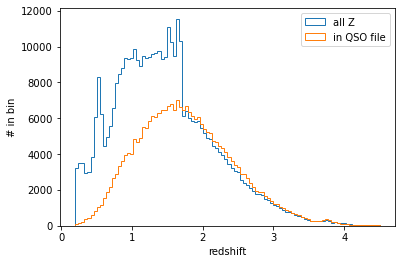

In [11]:
selobs = fq['SPECTYPE'] != 'N/A'
plt.hist(fq[selobs]['Z_RR'],bins=100,range=(0.2,4.5),histtype='step',label='all Z')#,density=True)
selqso = fq['Z'] != 1e+20
plt.hist(fq[selqso]['Z'],bins=100,range=(0.2,4.5),histtype='step',label='in QSO file')#,density=True)
plt.xlabel('redshift')
plt.ylabel('# in bin')
plt.legend()
plt.show()

In [12]:
#overall completeness:
tarcomp = len(fq[selobs])/len(fq)
print(tarcomp)

0.7727432341140045


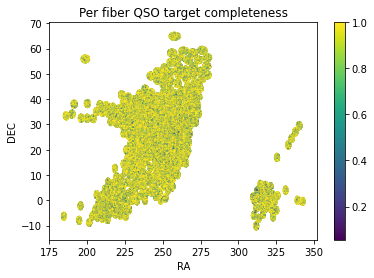

In [13]:
plt.scatter(fq[selobs]['RA'],fq[selobs]['DEC'],c=fq[selobs]['FRACZ_TILELOCID'],s=.05)
plt.colorbar()
#plt.xlim(220,240)
#plt.ylim(30,50)
plt.title('Per fiber QSO target completeness')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

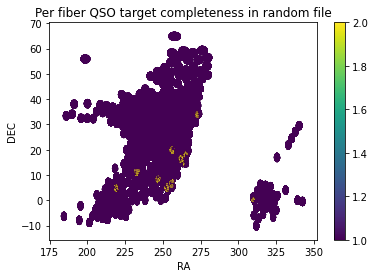

In [18]:
fqr = fitsio.read(indir+'QSOzdone_0_full.ran.fits')
plt.scatter(fqr['RA'],fqr['DEC'],c=fqr['NTILE'],s=.05)
plt.colorbar()
#plt.xlim(220,240)
#plt.ylim(30,50)
plt.title('Per fiber QSO target completeness in random file')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

In [17]:
fqr.dtype.names

('LOCATION',
 'FIBER',
 'TARGETID',
 'RA',
 'DEC',
 'TILEID',
 'ZWARN',
 'COADD_FIBERSTATUS',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y',
 'COADD_NUMEXP',
 'COADD_EXPTIME',
 'COADD_NUMNIGHT',
 'MEAN_DELTA_X',
 'RMS_DELTA_X',
 'MEAN_DELTA_Y',
 'RMS_DELTA_Y',
 'MEAN_PSF_TO_FIBER_SPECFLUX',
 'TSNR2_ELG_B',
 'TSNR2_LYA_B',
 'TSNR2_BGS_B',
 'TSNR2_QSO_B',
 'TSNR2_LRG_B',
 'TSNR2_ELG_R',
 'TSNR2_LYA_R',
 'TSNR2_BGS_R',
 'TSNR2_QSO_R',
 'TSNR2_LRG_R',
 'TSNR2_ELG_Z',
 'TSNR2_LYA_Z',
 'TSNR2_BGS_Z',
 'TSNR2_QSO_Z',
 'TSNR2_LRG_Z',
 'TSNR2_ELG',
 'TSNR2_LYA',
 'TSNR2_BGS',
 'TSNR2_QSO',
 'TSNR2_LRG',
 'TILELOCID',
 'NTILE',
 'TILES',
 'TILELOCIDS',
 'NOBS_G',
 'NOBS_R',
 'NOBS_Z',
 'MASKBITS',
 'PHOTSYS')

182.97445619817378


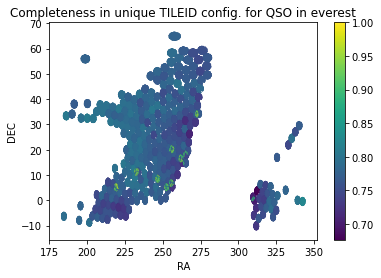

In [14]:
xlim = 0,360
ylim = -14,78

sel = fq['RA'] > xlim[0]
sel &= fq['RA'] < xlim[1]
sel &= fq['DEC'] > ylim[0]
sel &= fq['DEC'] < ylim[1]
fbds = fq[sel]
ra = fq['RA']
selra = ra < 110
ra[selra] += 360
print(min(ra))
gridsize=int(8*(np.max(ra)-np.min(ra)))
plt.hexbin(ra,fbds['DEC'],fbds['COMP_TILE'],gridsize=gridsize)
plt.colorbar()
#plt.xlim(307,332)
#plt.ylim(-8,17)
plt.title('Completeness in unique TILEID config. for QSO in everest')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

182.97445619817378


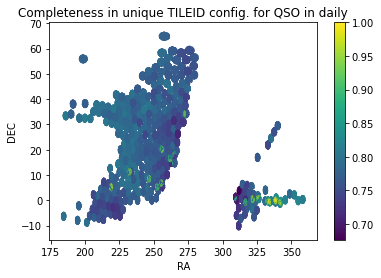

In [12]:
xlim = 0,360
ylim = -14,78

sel = fqd['RA'] > xlim[0]
sel &= fqd['RA'] < xlim[1]
sel &= fqd['DEC'] > ylim[0]
sel &= fqd['DEC'] < ylim[1]
fbds = fqd[sel]
ra = fbds['RA']
selra = ra < 110
ra[selra] += 360
print(min(ra))
gridsize=int(8*(np.max(ra)-np.min(ra)))
plt.hexbin(ra,fbds['DEC'],fbds['COMP_TILE'],gridsize=gridsize)
plt.colorbar()
#plt.xlim(307,332)
#plt.ylim(-8,17)
plt.title('Completeness in unique TILEID config. for QSO in daily')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

In [106]:
fqr = fitsio.read(indir+'/QSOzdone_0_clustering.ran.fits')
#fqr = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs//main/LSS/everest//rancomb_0darkwdupspec_zdone.fits')
#there are 18 random files, numbers 0-17; 'alltiles' will switch to 'zdone' in the future in the file name

In [107]:
#randoms have density of 2500/deg2
#so, the QSO footprint size is
sqf = len(fqr)/2500
print(str(sqf)+' deg2')

1609.8168 deg2


In [110]:
len(fqr)
#len(np.unique(fqr['TILEID']))

4024542

In [108]:
fq = fitsio.read(indir+'QSOzdone_clustering.dat.fits')
print(len(fq))

245891


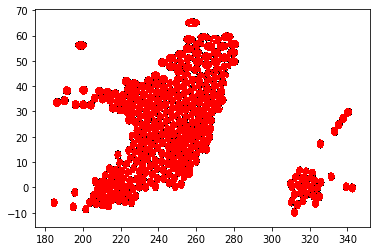

In [109]:
plt.plot(fqr['RA'],fqr['DEC'],'k,')
plt.plot(fq['RA'],fq['DEC'],'r,')

In [34]:
sellya = selobs.copy()
sellya &= fq['Z'] > 2.1
sellya |= (fq['IS_QSO_QN'] == 1) & (fq['Z_QN'] > 2.1)
print(len(fq[sellya]))

50156


In [52]:
lydens = len(fq[sellya])/sqf/tarcomp
print('The lyman-alpha density is '+str(round(lydens,2))+'/deg2')

The lyman-alpha density is 58.67/deg2


## The area is pretty big, so we can start looking for systematic trends in sky density within redshift ranges

<ipython-input-77-f8329a11767f>:6: RuntimeWarning: divide by zero encountered in log
  hd = np.histogram(np.log(qc['PSFDEPTH_R']),weights=tarcomp/qc['COMP_TILE'],range=(4.5,np.log(1500)))


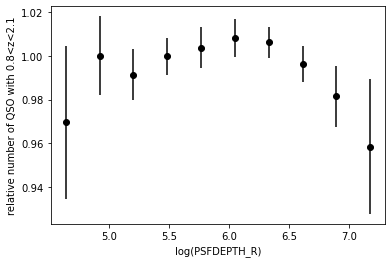

In [77]:
#just an example
selqc = fq['SPECTYPE'] == 'QSO'
selqc &= fq['Z'] > 1
selqc &= fq['Z'] < 2.1
qc = fq[selqc]
hd = np.histogram(np.log(qc['PSFDEPTH_R']),weights=tarcomp/qc['COMP_TILE'],range=(4.5,np.log(1500)))
hr = np.histogram(np.log(fqr['PSFDEPTH_R']),bins=hd[1])
norm = sum(hr[0])/sum(hd[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
plt.errorbar(xl,hd[0]/hr[0]*norm,np.sqrt(hd[0])/hr[0]*norm,fmt='ko')
plt.xlabel('log(PSFDEPTH_R)')
plt.ylabel('relative number of QSO with 0.8<z<2.1')
plt.show()

In [ ]:
#smoothness is strange...maybe something is not correct with approximate error-bars

## Now look at BGS

In [28]:
fbd = fitsio.read(indaily+'BGS_ANYzdone_full.dat.fits')

In [274]:
fbc = fitsio.read(indir+'BGS_ANYzdone_clustering.dat.fits')
print(len(fbc))

971577


976983


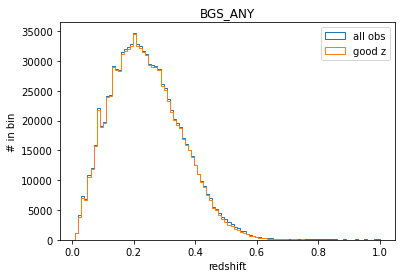

In [216]:
selobs = fb['SPECTYPE'] != 'N/A'
plt.hist(fb[selobs]['Z'],bins=100,range=(0.01,1),histtype='step',label='all obs')#,density=True)
selgz = selobs & (fb['ZWARN'] == 0)
selgz &= fb['DELTACHI2'] > 40
plt.hist(fb[selgz]['Z'],bins=100,range=(0.01,1),histtype='step',label='good z')#,density=True)
print(len(fb[selgz]))
plt.xlabel('redshift')
plt.ylabel('# in bin')
plt.legend()
plt.title('BGS_ANY')
plt.show()

In [217]:
#overall completeness:
tarcompb = len(fb[selobs])/len(fb)
print(tarcompb)

0.38689468199275356


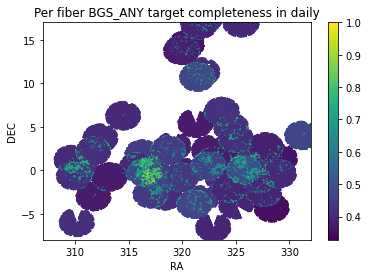

In [37]:
selobs = fbd['COADD_FIBERSTATUS'] == 0
plt.scatter(fbd[selobs]['RA'],fbd[selobs]['DEC'],c=fbd[selobs]['COMP_TILE'],s=.5)
plt.colorbar()
#plt.xlim(220,240)
#plt.ylim(30,50)
plt.xlim(307,332)
plt.ylim(-8,17)

plt.title('Per fiber BGS_ANY target completeness in daily')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

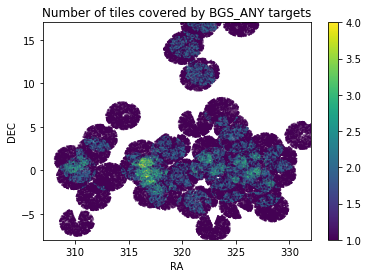

In [40]:
plt.scatter(fbd['RA'],fbd['DEC'],c=fbd['NTILE'],s=.01)
plt.colorbar()
plt.xlim(307,332)
plt.ylim(-8,17)
plt.title('Number of tiles covered by BGS_ANY targets')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

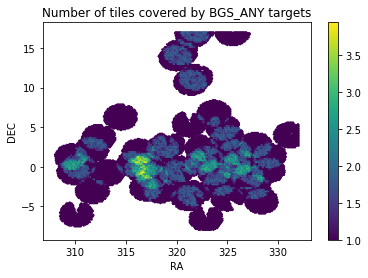

In [45]:
xlim = 307,332
ylim = -8,17
gridsize=8*(xlim[1]-xlim[0])
sel = fbd['RA'] > xlim[0]
sel &= fbd['RA'] < xlim[1]
sel &= fbd['DEC'] > ylim[0]
sel &= fbd['DEC'] < ylim[1]
fbds = fbd[sel]
plt.hexbin(fbds['RA'],fbds['DEC'],fbds['NTILE'],gridsize=gridsize)
plt.colorbar()
#plt.xlim(307,332)
#plt.ylim(-8,17)
plt.title('Number of tiles covered by BGS_ANY targets')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

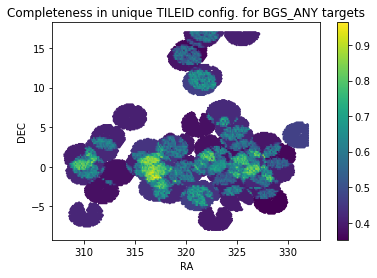

In [46]:
xlim = 307,332
ylim = -8,17
gridsize=8*(xlim[1]-xlim[0])
sel = fbd['RA'] > xlim[0]
sel &= fbd['RA'] < xlim[1]
sel &= fbd['DEC'] > ylim[0]
sel &= fbd['DEC'] < ylim[1]
fbds = fbd[sel]
plt.hexbin(fbds['RA'],fbds['DEC'],fbds['COMP_TILE'],gridsize=gridsize)
plt.colorbar()
#plt.xlim(307,332)
#plt.ylim(-8,17)
plt.title('Completeness in unique TILEID config. for BGS_ANY targets')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

175.48424780032812


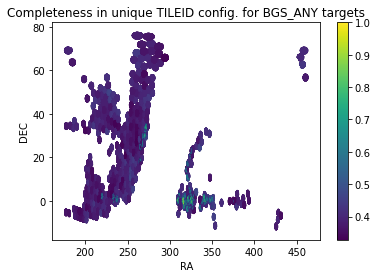

In [61]:
#xlim = min(fbd['RA']),max(fbd['RA'])
#ylim = min(fbd['DEC']),max(fbd['DEC'])
#print(xlim,ylim)
xlim = 0,360
ylim = -14,78

sel = fbd['RA'] > xlim[0]
sel &= fbd['RA'] < xlim[1]
sel &= fbd['DEC'] > ylim[0]
sel &= fbd['DEC'] < ylim[1]
fbds = fbd[sel]
ra = fbds['RA']
selra = ra < 110
ra[selra] += 360
print(min(ra))
gridsize=int(8*(np.max(ra)-np.min(ra)))
plt.hexbin(ra,fbds['DEC'],fbds['COMP_TILE'],gridsize=gridsize)
plt.colorbar()
#plt.xlim(307,332)
#plt.ylim(-8,17)
plt.title('Completeness in unique TILEID config. for BGS_ANY targets')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

308.059301409698


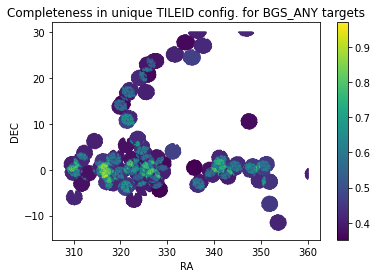

In [64]:
#xlim = min(fbd['RA']),max(fbd['RA'])
#ylim = min(fbd['DEC']),max(fbd['DEC'])
#print(xlim,ylim)
xlim = 305,360
ylim = -22.5,30

sel = fbd['RA'] > xlim[0]
sel &= fbd['RA'] < xlim[1]
sel &= fbd['DEC'] > ylim[0]
sel &= fbd['DEC'] < ylim[1]
fbds = fbd[sel]
ra = fbds['RA']
selra = ra < 110
ra[selra] += 360
print(min(ra))
gridsize=int(8*(np.max(ra)-np.min(ra)))
plt.hexbin(ra,fbds['DEC'],fbds['COMP_TILE'],gridsize=gridsize)
plt.colorbar()
#plt.xlim(307,332)
#plt.ylim(-8,17)
plt.title('Completeness in unique TILEID config. for BGS_ANY targets')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

In [ ]:
#xlim = min(fbd['RA']),max(fbd['RA'])
#ylim = min(fbd['DEC']),max(fbd['DEC'])
#print(xlim,ylim)
xlim = 305,360
ylim = -22.5,30

sel = fbd['RA'] > xlim[0]
sel &= fbd['RA'] < xlim[1]
sel &= fbd['DEC'] > ylim[0]
sel &= fbd['DEC'] < ylim[1]
fbds = fbd[sel]
ra = fbds['RA']
selra = ra < 110
ra[selra] += 360
print(min(ra))
gridsize=int(8*(np.max(ra)-np.min(ra)))
plt.hexbin(ra,fbds['DEC'],fbds['NTILE'],gridsize=gridsize)
plt.colorbar()
#plt.xlim(307,332)
#plt.ylim(-8,17)
plt.title('Number of TILEID covering BGS_ANY targets')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

308.059301409698


In [22]:
fs = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/main/LSS/daily/datcomb_bright_spec_zdone.fits')

In [26]:
sel = fs['COADD_FIBERSTATUS'] == 999999

In [27]:
len(np.unique(fs[sel]['TILEID']))

337

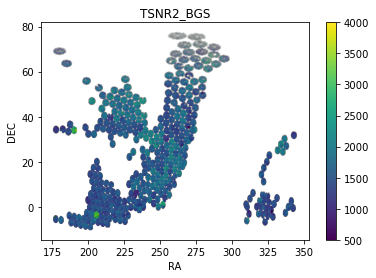

In [273]:
plt.scatter(fb[selobs]['RA'],fb[selobs]['DEC'],c=fb[selobs]['TSNR2_BGS'],s=.00001,vmin=500,vmax=4000)
plt.colorbar()
#plt.xlim(220,240)
#plt.ylim(30,50)
plt.title('TSNR2_BGS')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

996809 976983
996809 976983


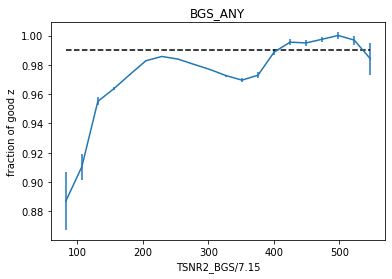

In [295]:
#Look at redshift efficiency
tp = 'BGS'
selobs = fb['SPECTYPE'] != 'N/A'
#selobs &= fb['TSNR2_BGS'] != 1e20
wzg = (fb['ZWARN'] == 0)
wzg &= (fb['DELTACHI2'] > 40)
print(len(fb[selobs]),len(fb[wzg]))

rng = (500,4000)
nb = 20
bs = (rng[1]-rng[0])/nb    

b = np.histogram(fb[selobs]['TSNR2_'+tp],bins=nb,range=rng)
a = np.histogram(fb[wzg]['TSNR2_'+tp],bins=nb,range=rng)
print(len(fb[selobs]),len(fb[wzg]))
dl = a[0]/b[0]#/fr
varl = dl*a[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr
vs = a[1][:-1]+bs/2.
plt.errorbar(vs/7.15,dl,el)        
plt.title(tp+'_ANY')
plt.xlabel('TSNR2_'+tp+'/7.15')
plt.ylabel('fraction of good z')
ol = np.ones(len(dl))*.99
plt.plot(vs/7.15,ol,'k--')
#plt.legend(loc='upper left')
plt.show()        

<ipython-input-250-159f6705820c>:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.hist(fb[selobs]['TSNR2_BGS']/fb[selobs]['EFFTIME_ETC']/7.15,range=(0.7,2))


Text(0.5, 0, 'TSNR2_BGS/EFFTIME_ETC/7.15')

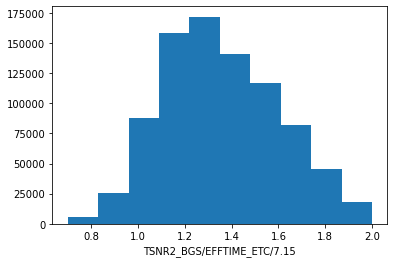

In [250]:
plt.hist(fb[selobs]['TSNR2_BGS']/fb[selobs]['EFFTIME_ETC']/7.15,range=(0.7,2))
plt.xlabel('TSNR2_BGS/EFFTIME_ETC/7.15')

(array([  1930.,  16174.,  85378., 226007., 261267., 192889., 128063.,
         58253.,  17009.,   4161.]),
 array([0.4 , 0.53, 0.66, 0.79, 0.92, 1.05, 1.18, 1.31, 1.44, 1.57, 1.7 ],
       dtype=float32),
 <a list of 10 Patch objects>)

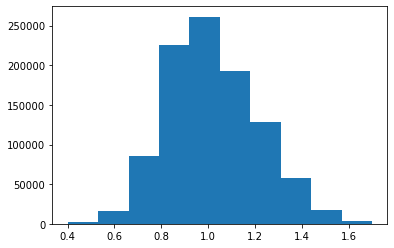

In [252]:
plt.hist(fb[selobs]['TSNR2_BGS']/np.median(fb[selobs]['TSNR2_BGS']),range=(0.4,1.7))

Text(0.5, 0, 'TSNR2_BGS/7.15')

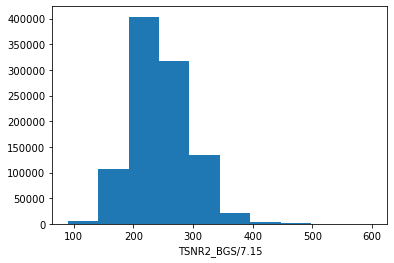

In [259]:
plt.hist(fb[selobs]['TSNR2_BGS']/7.15,range=(90,600))
plt.xlabel('TSNR2_BGS/7.15')

In [248]:
np.median(fb[selobs]['TSNR2_BGS']/fb[selobs]['EFFTIME_SPEC'])

7.149883676640356

In [235]:
np.max(fb[selobs]['TSNR2_BGS'])

1e+20

In [226]:
mtld = Table.read('/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/ops/tiles-specstatus.ecsv')

In [229]:
fb = join(fb,mtld,keys=['TILEID'])

In [238]:
len(fb)

2576435

In [264]:
np.unique(fb['PRIORITY'],return_counts=True)

(<Column name='PRIORITY' dtype='int64' length=4>
    2
 2000
 2100
 2998,
 array([     41,  804549, 1771839,       6]))

<ipython-input-306-7364078b489c>:4: RuntimeWarning: divide by zero encountered in true_divide
  plt.hist(mtld[sel]['EFFTIME_GFA']/mtld[sel]['EFFTIME_ETC'],bins=40,range=(.7,1.6))
<ipython-input-306-7364078b489c>:4: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(mtld[sel]['EFFTIME_GFA']/mtld[sel]['EFFTIME_ETC'],bins=40,range=(.7,1.6))


(array([ 0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  2.,  1., 16.,
        15., 50., 54., 51., 39., 16., 13.,  4.,  1.,  1.,  3.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]),
 array([0.7   , 0.7225, 0.745 , 0.7675, 0.79  , 0.8125, 0.835 , 0.8575,
        0.88  , 0.9025, 0.925 , 0.9475, 0.97  , 0.9925, 1.015 , 1.0375,
        1.06  , 1.0825, 1.105 , 1.1275, 1.15  , 1.1725, 1.195 , 1.2175,
        1.24  , 1.2625, 1.285 , 1.3075, 1.33  , 1.3525, 1.375 , 1.3975,
        1.42  , 1.4425, 1.465 , 1.4875, 1.51  , 1.5325, 1.555 , 1.5775,
        1.6   ]),
 <a list of 40 Patch objects>)

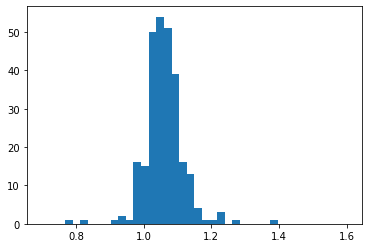

In [306]:
sel = (mtld['ZDONE'] == 'true')
sel &= (mtld['FAPRGRM']=='dark')
sel &= (mtld['SURVEY']=='main')
plt.hist(mtld[sel]['EFFTIME_GFA']/mtld[sel]['EFFTIME_ETC'],bins=40,range=(.7,1.6))

In [308]:
sel &= mtld['EFFTIME_ETC'] != 0
np.median(mtld[sel]['EFFTIME_GFA']/mtld[sel]['EFFTIME_ETC'])

1.058137294025809

<ipython-input-309-ea2f9612069e>:4: RuntimeWarning: divide by zero encountered in true_divide
  plt.hist(mtld[sel]['EFFTIME_GFA']/mtld[sel]['EFFTIME_ETC'],bins=40,range=(.7,1.6))


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  3.,  3.,  6., 11.,  6., 18., 19., 23., 28., 20., 22.,
        23., 23., 21., 21., 12., 12., 11.,  7.,  1.,  3.,  1.,  2.,  0.,
         0.]),
 array([0.7   , 0.7225, 0.745 , 0.7675, 0.79  , 0.8125, 0.835 , 0.8575,
        0.88  , 0.9025, 0.925 , 0.9475, 0.97  , 0.9925, 1.015 , 1.0375,
        1.06  , 1.0825, 1.105 , 1.1275, 1.15  , 1.1725, 1.195 , 1.2175,
        1.24  , 1.2625, 1.285 , 1.3075, 1.33  , 1.3525, 1.375 , 1.3975,
        1.42  , 1.4425, 1.465 , 1.4875, 1.51  , 1.5325, 1.555 , 1.5775,
        1.6   ]),
 <a list of 40 Patch objects>)

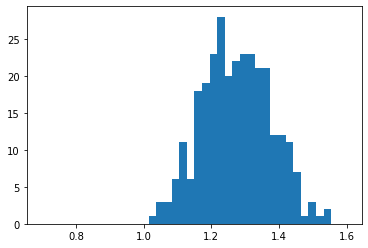

In [309]:
sel = (mtld['ZDONE'] == 'true')
sel &= (mtld['FAPRGRM']=='bright')
sel &= (mtld['SURVEY']=='main')
plt.hist(mtld[sel]['EFFTIME_GFA']/mtld[sel]['EFFTIME_ETC'],bins=40,range=(.7,1.6))

In [275]:
mtld.dtype.names

('TILEID',
 'SURVEY',
 'FAPRGRM',
 'FAFLAVOR',
 'NEXP',
 'EXPTIME',
 'TILERA',
 'TILEDEC',
 'EFFTIME_ETC',
 'EFFTIME_SPEC',
 'EFFTIME_GFA',
 'GOALTIME',
 'OBSSTATUS',
 'ZDONE',
 'ELG_EFFTIME_DARK',
 'BGS_EFFTIME_BRIGHT',
 'LYA_EFFTIME_DARK',
 'GOALTYPE',
 'MINTFRAC',
 'LASTNIGHT',
 'QA',
 'USER',
 'OVERRIDE')

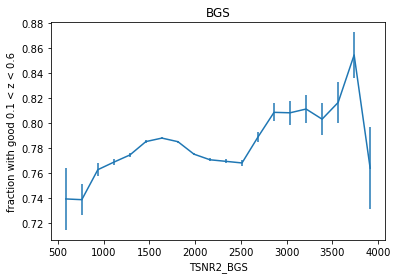

In [271]:
#Look at redshift efficiency, only for 0.05 < z < 0.6
zmin = 0.1
zmax = 0.4
tp = 'BGS'
wg = fb['ZWARN'] != 999999
wzg = fb['ZWARN'] == 0
wzg &= fb['DELTACHI2'] > 40
wzg &= fb['Z'] > zmin
wzg &= fb['Z'] < zmax

rng = (500,4000)
nb = 20
bs = (rng[1]-rng[0])/nb    

b = np.histogram(fb[wg]['TSNR2_'+tp],bins=nb,range=rng)
a = np.histogram(fb[wzg]['TSNR2_'+tp],bins=b[1])
dl = a[0]/b[0]#/fr
varl = dl*a[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr
vs = a[1][:-1]+bs/2.
plt.errorbar(vs,dl,el)        
plt.title(tp)
plt.xlabel('TSNR2_'+tp)
plt.ylabel('fraction with good 0.1 < z < 0.6')
ol = np.ones(len(dl))*.99
#plt.plot(vs,ol,'k--')
#plt.legend(loc='upper left')
plt.show()

In [266]:
fbr = fitsio.read(indir+'BGS_ANYzdone_0_full.ran.fits')

In [267]:
#look at area again
ba = len(fbr)/2500
print(str(ba)+' deg2')

1833.778 deg2


In [268]:
#just an example; note no split in BASS/MzLS / DECaLS 
selobs = fb['SPECTYPE'] != 'N/A'
selz = selobs & (fb['ZWARN'] == 0)
selz &= fb['DELTACHI2'] > 40
selz &= fb['Z'] > 0.01
selz &= fb['Z'] < 0.6

bc = fb[selz]
hd = np.histogram(np.log(bc['GALDEPTH_R']),weights=tarcompb/bc['COMP_TILE'],range=(4.5,np.log(1500)))
hr = np.histogram(np.log(fbr['GALDEPTH_R']),bins=hd[1])
norm = sum(hr[0])/sum(hd[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
plt.errorbar(xl,hd[0]/hr[0]*norm,np.sqrt(hd[0])/hr[0]*norm,fmt='ko')
plt.xlabel('log(GALDEPTH_R)')
plt.ylabel('relative number of BGS_ANY with 0.01<z<0.6')
plt.show()

<ipython-input-268-c4d513274e33>:9: RuntimeWarning: divide by zero encountered in log
  hd = np.histogram(np.log(bc['GALDEPTH_R']),weights=tarcompb/bc['COMP_TILE'],range=(4.5,np.log(1500)))


ValueError: no field of name GALDEPTH_R

## LRG

In [6]:
fl = fitsio.read(indir+'LRGzdone_full.dat.fits')
fld = fitsio.read(indaily+'LRGzdone_full.dat.fits')

In [12]:
fc = fitsio.read(indir+'QSOzdone_clustering.dat.fits')

In [13]:
fc.dtype.names

('TARGETID', 'RA', 'DEC', 'NTILE', 'TILES', 'Z', 'WEIGHT', 'NZ')

In [17]:
from desispec.io import specprod_root

In [20]:
os.path.expandvars('$DESI_SPECTRO_REDUX/')

'/global/cfs/cdirs/desi/spectro/redux/'

In [21]:
os.path.expandvars('$DESI_ROOT/')

'/global/cfs/cdirs/desi/'

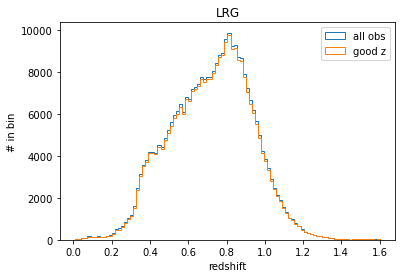

In [28]:
selobs = fl['SPECTYPE'] != 'N/A'
plt.hist(fl[selobs]['Z'],bins=100,range=(0.01,1.6),histtype='step',label='all obs')#,density=True)
selgz = selobs & (fl['ZWARN'] == 0)
selgz &= fl['DELTACHI2'] > 16
plt.hist(fl[selgz]['Z'],bins=100,range=(0.01,1.6),histtype='step',label='good z')#,density=True)
plt.xlabel('redshift')
plt.ylabel('# in bin')
plt.legend()
plt.title('LRG')
plt.show()

In [29]:
#overall completeness:
tarcompl = len(fl[selobs])/len(fl)
print(tarcompl)

0.581522743694443


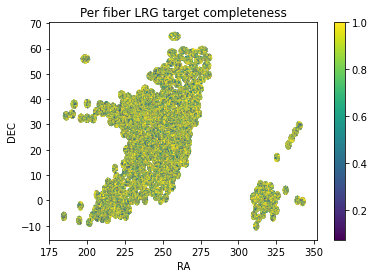

In [30]:
plt.scatter(fl[selobs]['RA'],fl[selobs]['DEC'],c=fl[selobs]['FRACZ_TILELOCID'],s=.05)
plt.colorbar()
#plt.xlim(220,240)
#plt.ylim(30,50)
plt.title('Per fiber LRG target completeness')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

182.94711545532473


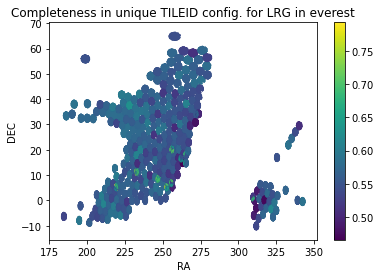

In [7]:
xlim = 0,360
ylim = -14,78

sel = fl['RA'] > xlim[0]
sel &= fl['RA'] < xlim[1]
sel &= fl['DEC'] > ylim[0]
sel &= fl['DEC'] < ylim[1]
fbds = fl[sel]
ra = fl['RA']
selra = ra < 110
ra[selra] += 360
print(min(ra))
gridsize=int(8*(np.max(ra)-np.min(ra)))
plt.hexbin(ra,fbds['DEC'],fbds['COMP_TILE'],gridsize=gridsize)
plt.colorbar()
#plt.xlim(307,332)
#plt.ylim(-8,17)
plt.title('Completeness in unique TILEID config. for LRG in everest')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

182.94711545532473


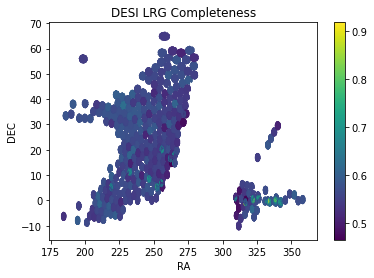

In [13]:
xlim = 0,360
ylim = -14,78

sel = fld['RA'] > xlim[0]
sel &= fld['RA'] < xlim[1]
sel &= fld['DEC'] > ylim[0]
sel &= fld['DEC'] < ylim[1]
fbds = fld[sel]
ra = fbds['RA']
selra = ra < 110
ra[selra] += 360
print(min(ra))
gridsize=int(8*(np.max(ra)-np.min(ra)))
plt.hexbin(ra,fbds['DEC'],fbds['COMP_TILE'],gridsize=gridsize)
plt.colorbar()
#plt.xlim(307,332)
#plt.ylim(-8,17)
#plt.title('Completeness in unique TILEID config. for LRG in daily')
plt.title('DESI LRG Completeness')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

182.94711545532473


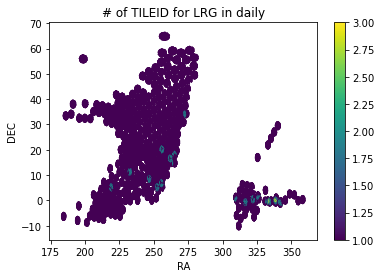

In [10]:
xlim = 0,360
ylim = -14,78

sel = fld['RA'] > xlim[0]
sel &= fld['RA'] < xlim[1]
sel &= fld['DEC'] > ylim[0]
sel &= fld['DEC'] < ylim[1]
fbds = fld[sel]
ra = fbds['RA']
selra = ra < 110
ra[selra] += 360
print(min(ra))
gridsize=int(8*(np.max(ra)-np.min(ra)))
plt.hexbin(ra,fbds['DEC'],fbds['NTILE'],gridsize=gridsize)
plt.colorbar()
#plt.xlim(307,332)
#plt.ylim(-8,17)
plt.title('# of TILEID for LRG in daily')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

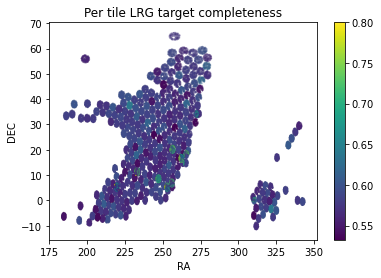

In [31]:
plt.scatter(fl[selobs]['RA'],fl[selobs]['DEC'],c=fl[selobs]['COMP_TILE'],s=.001)
plt.colorbar()
#plt.xlim(220,240)
#plt.ylim(30,50)
plt.title('Per tile LRG target completeness')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

In [66]:
drz = (10**(3 - 3.5*fl['Z']))
mask_bad = (drz>30) & (fl['DELTACHI2']<30)
mask_bad |= (drz<30) & (fl['DELTACHI2']<drz)
mask_bad |= (fl['DELTACHI2']<10)
wz = fl['ZWARN'] == 0
wz &= fl['Z']<1.4
wz &= (~mask_bad)


460836
320743


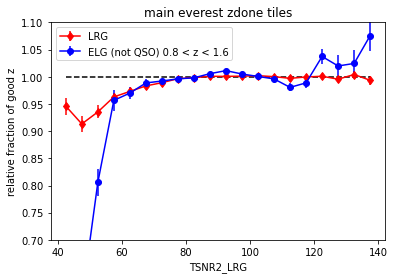

In [91]:
#Look at redshift efficiency
tp = 'LRG'
wg = fl['ZWARN'] != 999999
#wzg = fl['ZWARN'] == 0
wzg = wg & wz

rng = (40,140)
nb = 20
bs = (rng[1]-rng[0])/nb    

b = np.histogram(fl[wg]['TSNR2_'+tp],bins=nb,range=rng)
a = np.histogram(fl[wzg]['TSNR2_'+tp],bins=b[1])
dl = a[0]/b[0]#/fr
varl = dl*a[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr
vs = a[1][:-1]+bs/2.
plt.errorbar(vs,dl/.978,el/.978,fmt='r-d',label='LRG')
#compare to ELG, loaded below
wg = fe['ZWARN'] != 999999
print(len(fe[wg]))
wg &= ((fe['DESI_TARGET'] & targetmask.desi_mask['QSO']) == 0)
print(len(fe[wg]))
wzg = wg & (fe['o2c'] > 0.9)
zmin = 0.8
zmax = 1.6
wzg &= fe['Z'] > zmin
wzg &= fe['Z'] < zmax

b = np.histogram(fe[wg]['TSNR2_'+tp],bins=nb,range=rng)
a = np.histogram(fe[wzg]['TSNR2_'+tp],bins=b[1])
dl = a[0]/b[0]#/fr
varl = dl*a[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr
vs = a[1][:-1]+bs/2.
plt.errorbar(vs,dl/.61,el/.61,fmt='b-o',label='ELG (not QSO) 0.8 < z < 1.6') 
plt.title('main everest zdone tiles')
plt.xlabel('TSNR2_'+tp)
plt.ylabel('relative fraction of good z')
plt.legend()
ol = np.ones(len(dl))#*.975
plt.plot(vs,ol,'k--')
#plt.legend(loc='upper left')
plt.ylim(0.7,1.1)
plt.show()        

Text(0, 0.5, '#')

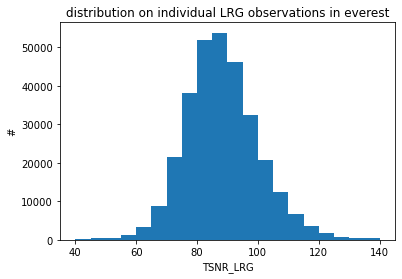

In [37]:
plt.hist(fl[wg]['TSNR2_'+tp],bins=20,range=(40,140))
plt.title('distribution on individual LRG observations in everest')
plt.xlabel('TSNR_LRG')
plt.ylabel('#')

In [208]:
flr = fitsio.read(indir+'LRGzdone_0_full.ran.fits')

In [114]:
print(len(flr))
#look at area again
la = len(flr)/2500
print(str(la)+' deg2')

2954986
1181.9944 deg2


In [203]:
fl = fitsio.read(indir+'LRGzdone_full.dat.fits')

In [18]:
flc = fitsio.read(indir+'LRGzdone_clustering.dat.fits')
len(flc)

302494

<ipython-input-209-f626579b43b4>:9: RuntimeWarning: divide by zero encountered in log
  hd = np.histogram(np.log(lc['GALDEPTH_Z']),weights=1./lc['COMP_TILE'],range=(2.5,5.))


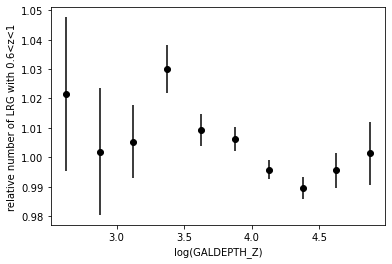

In [209]:
#just an example; note no split in BASS/MzLS / DECaLS 
selobs = fl['SPECTYPE'] != 'N/A'
selz = selobs & (fl['ZWARN'] == 0)
selz &= fl['DELTACHI2'] > 16
selz &= fl['Z'] > 0.6
selz &= fl['Z'] < 1

lc = fl[selz]
hd = np.histogram(np.log(lc['GALDEPTH_Z']),weights=1./lc['COMP_TILE'],range=(2.5,5.))
hr = np.histogram(np.log(flr['GALDEPTH_Z']),bins=hd[1])
norm = sum(hr[0])/sum(hd[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
plt.errorbar(xl,hd[0]/hr[0]*norm,np.sqrt(hd[0])/hr[0]*norm,fmt='ko')
plt.xlabel('log(GALDEPTH_Z)')
plt.ylabel('relative number of LRG with 0.6<z<1')
plt.show()

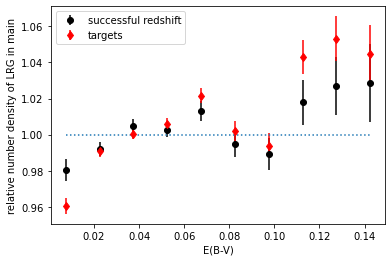

In [211]:
#just an example; note no split in BASS/MzLS / DECaLS 
selobs = fl['SPECTYPE'] != 'N/A'
selz = selobs & (fl['ZWARN'] == 0)
drz = (10**(3 - 3.5*fl['Z']))
mask_bad = (drz>30) & (fl['DELTACHI2']<30)
mask_bad |= (drz<30) & (fl['DELTACHI2']<drz)
mask_bad |= (fl['DELTACHI2']<10)
selz &= fl['Z']<1.4
selz &= (~mask_bad)

lc = fl[selz]
hd = np.histogram(lc['EBV'],weights=tarcompl/lc['COMP_TILE'],range=(0,.15))
hr = np.histogram(flr['EBV'],bins=hd[1])
hdr = np.histogram(fl['EBV'],range=(0,.15))
norm = sum(hr[0])/sum(hd[0])
normr = sum(hr[0])/sum(hdr[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
plt.errorbar(xl,hd[0]/hr[0]*norm,np.sqrt(hd[0])/hr[0]*norm,fmt='ko',label='successful redshift')
plt.errorbar(xl,hdr[0]/hr[0]*normr,np.sqrt(hdr[0])/hr[0]*normr,fmt='rd',label='targets')
ol = np.ones(len(xl))
plt.plot(xl,ol,':')
plt.xlabel('E(B-V)')
plt.ylabel('relative number density of LRG in main')
plt.legend()
plt.show()

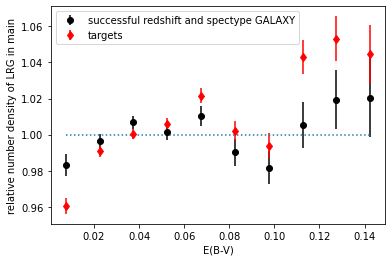

In [213]:
#just an example; note no split in BASS/MzLS / DECaLS 
selobs = fl['SPECTYPE'] == 'GALAXY'
selz = selobs & (fl['ZWARN'] == 0)
drz = (10**(3 - 3.5*fl['Z']))
mask_bad = (drz>30) & (fl['DELTACHI2']<30)
mask_bad |= (drz<30) & (fl['DELTACHI2']<drz)
mask_bad |= (fl['DELTACHI2']<10)
selz &= fl['Z']<1.4
selz &= (~mask_bad)

lc = fl[selz]
hd = np.histogram(lc['EBV'],weights=tarcompl/lc['COMP_TILE'],range=(0,.15))
hr = np.histogram(flr['EBV'],bins=hd[1])
hdr = np.histogram(fl['EBV'],range=(0,.15))
norm = sum(hr[0])/sum(hd[0])
normr = sum(hr[0])/sum(hdr[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
plt.errorbar(xl,hd[0]/hr[0]*norm,np.sqrt(hd[0])/hr[0]*norm,fmt='ko',label='successful redshift and spectype GALAXY')
plt.errorbar(xl,hdr[0]/hr[0]*normr,np.sqrt(hdr[0])/hr[0]*normr,fmt='rd',label='targets')
ol = np.ones(len(xl))
plt.plot(xl,ol,':')
plt.xlabel('E(B-V)')
plt.ylabel('relative number density of LRG in main')
plt.legend()
plt.show()

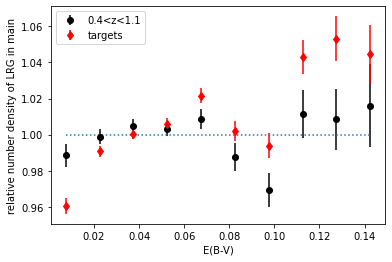

In [214]:
#just an example; note no split in BASS/MzLS / DECaLS 
selobs = fl['SPECTYPE'] == 'GALAXY'
selz = selobs & (fl['ZWARN'] == 0)
drz = (10**(3 - 3.5*fl['Z']))
mask_bad = (drz>30) & (fl['DELTACHI2']<30)
mask_bad |= (drz<30) & (fl['DELTACHI2']<drz)
mask_bad |= (fl['DELTACHI2']<10)
selz &= fl['Z']<1.4
selz &= (~mask_bad)
selz &= fl['Z'] > 0.4
selz &= fl['Z'] < 1.1

lc = fl[selz]
hd = np.histogram(lc['EBV'],weights=tarcompl/lc['COMP_TILE'],range=(0,.15))
hr = np.histogram(flr['EBV'],bins=hd[1])
hdr = np.histogram(fl['EBV'],range=(0,.15))
norm = sum(hr[0])/sum(hd[0])
normr = sum(hr[0])/sum(hdr[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
plt.errorbar(xl,hd[0]/hr[0]*norm,np.sqrt(hd[0])/hr[0]*norm,fmt='ko',label='0.4<z<1.1')
plt.errorbar(xl,hdr[0]/hr[0]*normr,np.sqrt(hdr[0])/hr[0]*normr,fmt='rd',label='targets')
ol = np.ones(len(xl))
plt.plot(xl,ol,':')
plt.xlabel('E(B-V)')
plt.ylabel('relative number density of LRG in main')
plt.legend()
plt.show()

## And finaly ELG

In [3]:
fe = fitsio.read(indir+'ELG_LOPzdone_full.dat.fits')

(array([    0.,  1710., 16923., 20092., 37462., 76373., 77870., 97016.,
        98070., 83873.]),
 array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045, 0.05 ], dtype=float32),
 <a list of 10 Patch objects>)

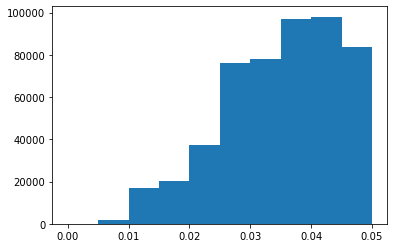

In [6]:
sel = fe['PHOTSYS'] == 'S'
plt.hist(fe[sel]['EBV'],range=(0,0.05))

(array([  2563.,  28910.,  90890., 163912., 220958., 177600., 111566.,
         58132.,  31181.,  15500.]),
 array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800., 2000.], dtype=float32),
 <a list of 10 Patch objects>)

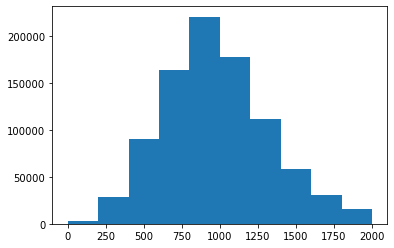

In [9]:
plt.hist(fe[sel]['GALDEPTH_G'],range=(0,2000))

418155
242235
198212


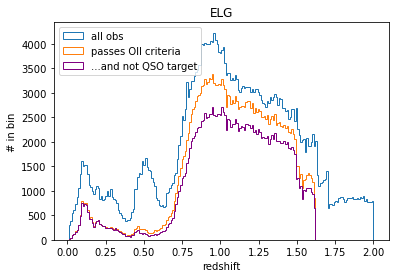

In [144]:
selobs = fe['SPECTYPE'] != 'N/A'
print(len(fe[selobs]))
plt.hist(fe[selobs]['Z'],bins=200,range=(0.01,2),histtype='step',label='all obs')#,density=True)
selgz = selobs & (fe['o2c'] > 0.9)
print(len(fe[selgz]))
plt.hist(fe[selgz]['Z'],bins=200,range=(0.01,2),histtype='step',label='passes OII criteria')#,density=True)
selnqgz = selgz & ((fe['DESI_TARGET'] & targetmask.desi_mask['QSO']) == 0)
print(len(fe[selnqgz]))
plt.hist(fe[selnqgz]['Z'],bins=200,range=(0.01,2),histtype='step',label='...and not QSO target',color='purple')#,density=True)
selnvgz = selnqgz & ((fe['DESI_TARGET'] & targetmask.desi_mask['ELG_VLO']) == 0)
#plt.hist(fe[selnvgz]['Z'],bins=200,range=(0.01,2),histtype='step',label='...and not VLO target',color='green')#,density=True)

plt.xlabel('redshift')
plt.ylabel('# in bin')
plt.legend(loc='upper left')
plt.title('ELG')
plt.show()

In [140]:
np.mean(fe[selobs]['o2c'])

1e+20

(array([0., 0., 0.]), array([-1,  0,  1,  2]), <a list of 3 Patch objects>)

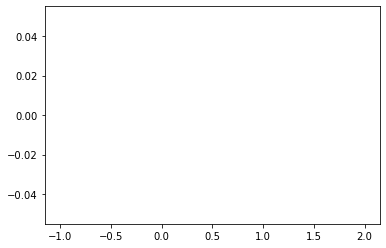

In [130]:
selobs = fe['SPECTYPE'] != 'N/A'
plt.hist(fe[selobs]['o2c'],range(-1,3))

In [125]:
#overall completeness:
tarcompe = len(fe[selobs])/len(fe)
print(tarcompe)

0.27947595626552674


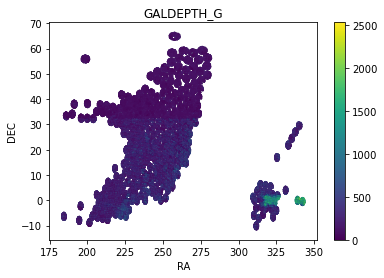

In [6]:
plt.scatter(fe['RA'],fe['DEC'],c=fe['GALDEPTH_R'],s=.001)
plt.colorbar()
#plt.xlim(220,240)
#plt.ylim(30,50)
plt.title('GALDEPTH_G')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

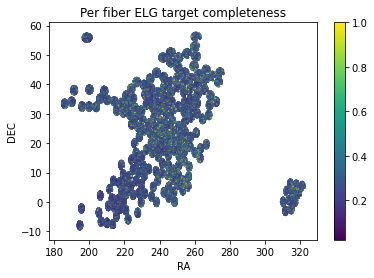

In [112]:
plt.scatter(fe[selobs]['RA'],fe[selobs]['DEC'],c=fe[selobs]['FRACZ_TILELOCID'],s=.05)
plt.colorbar()
#plt.xlim(220,240)
#plt.ylim(30,50)
plt.title('Per fiber ELG target completeness')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

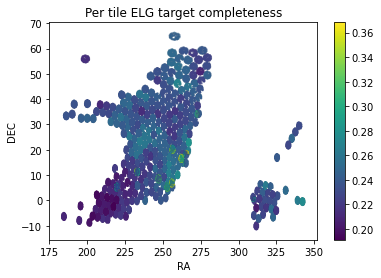

In [102]:
plt.scatter(fe[selobs]['RA'],fe[selobs]['DEC'],c=fe[selobs]['COMP_TILE'],s=.001)
plt.colorbar()
#plt.xlim(220,240)
#plt.ylim(30,50)
plt.title('Per tile ELG target completeness')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

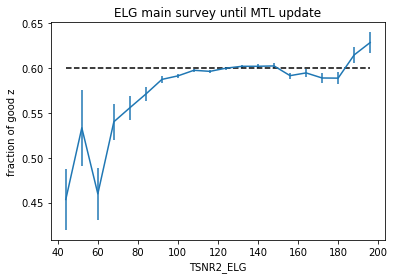

In [115]:
#Look at redshift efficiency
tp = 'ELG'
wg = fe['ZWARN'] != 999999
wzg = wg & (fe['o2c'] > 0.9)

rng = (40,200)
nb = 20
bs = (rng[1]-rng[0])/nb    

b = np.histogram(fe[wg]['TSNR2_'+tp],bins=nb,range=rng)
a = np.histogram(fe[wzg]['TSNR2_'+tp],bins=b[1])
dl = a[0]/b[0]#/fr
varl = dl*a[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr
vs = a[1][:-1]+bs/2.
plt.errorbar(vs,dl,el)        
plt.title(tp+' main survey until MTL update')
plt.xlabel('TSNR2_'+tp)
plt.ylabel('fraction of good z')
#plt.legend(loc='upper left')
ol = np.ones(len(dl))*(.6)
plt.plot(vs,ol,'k--')
plt.show()        

In [118]:
selnoq = fe['DESI_TARGET'] & targetmask.desi_mask['QSO'] == 0

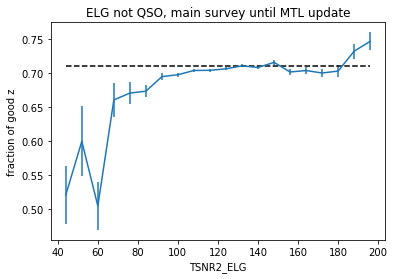

In [119]:
#repeat, removing QSO targets
tp = 'ELG'
wg = selnoq & (fe['ZWARN'] != 999999) 
wzg = wg & (fe['o2c'] > 0.9) 

rng = (40,200)
nb = 20
bs = (rng[1]-rng[0])/nb    

b = np.histogram(fe[wg]['TSNR2_'+tp],bins=nb,range=rng)
a = np.histogram(fe[wzg]['TSNR2_'+tp],bins=b[1])
dl = a[0]/b[0]#/fr
varl = dl*a[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr
vs = a[1][:-1]+bs/2.
plt.errorbar(vs,dl,el)        
plt.title(tp+' not QSO, main survey until MTL update')
plt.xlabel('TSNR2_'+tp)
plt.ylabel('fraction of good z')
#plt.legend(loc='upper left')
ol = np.ones(len(dl))*(.71)
plt.plot(vs,ol,'k--')
plt.show()        

In [33]:
#fe = fitsio.read(indir+'ELGzdone_clustering.dat.fits')
fer = fitsio.read(indir+'ELG_LOPzdone_0_full.ran.fits')
print(len(fe),len(fer))

1496211 1858996


In [19]:
fec = fitsio.read(indir+'ELGzdone_clustering.dat.fits')
print(len(fec))

278228


In [146]:
#look at area again
ea = len(fer)/2500
print(str(ea)+' deg2')

743.5984 deg2


(array([1.90000e+01, 6.50000e+01, 1.23900e+03, 1.16050e+04, 1.22885e+05,
        5.57381e+05, 6.10328e+05, 4.55777e+05, 9.52360e+04, 4.46100e+03]),
 array([3.4489608, 3.9538872, 4.4588137, 4.9637403, 5.468667 , 5.9735937,
        6.47852  , 6.9834466, 7.4883733, 7.9932995, 8.498226 ],
       dtype=float32),
 <a list of 10 Patch objects>)

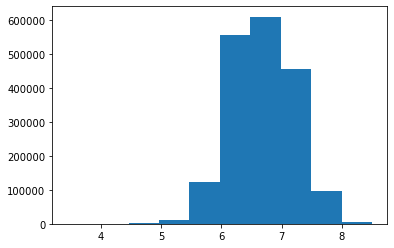

In [158]:
plt.hist(np.log(fer['GALDEPTH_G']))

<ipython-input-200-ea6b64994546>:8: RuntimeWarning: divide by zero encountered in log
  hd = np.histogram(np.log(ec['GALDEPTH_G']),weights=ec['WEIGHT_SYS']/ec['COMP_TILE'],range=(5.5,8.))
<ipython-input-200-ea6b64994546>:9: RuntimeWarning: divide by zero encountered in log
  hdo = np.histogram(np.log(ec['GALDEPTH_G']),weights=1./ec['COMP_TILE'],range=(5.5,8.))


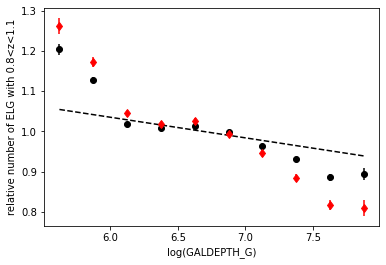

<ipython-input-200-ea6b64994546>:25: RuntimeWarning: divide by zero encountered in log
  hd = np.histogram(np.log(ec['GALDEPTH_G']),weights=ec['WEIGHT'],range=(5.5,8.))


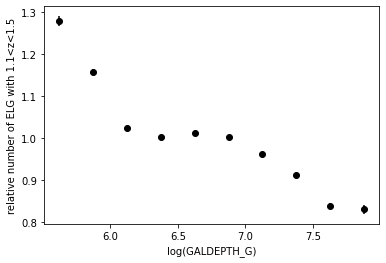

In [200]:
#just an example; note no split in BASS/MzLS / DECaLS and low completeness is probably pushing things for ELG 
selobs = fe['SPECTYPE'] != 'N/A'
selz = selobs & (fe['o2c'] > 0.9)
selz &= fe['Z'] > 0.8
selz &= fe['Z'] < 1.5

ec = fej[selz]
hd = np.histogram(np.log(ec['GALDEPTH_G']),weights=ec['WEIGHT_SYS']/ec['COMP_TILE'],range=(5.5,8.))
hdo = np.histogram(np.log(ec['GALDEPTH_G']),weights=1./ec['COMP_TILE'],range=(5.5,8.))
hr = np.histogram(np.log(fer['GALDEPTH_G']),bins=hd[1])
norm = sum(hr[0])/sum(hd[0])
normo = sum(hr[0])/sum(hdo[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
plt.errorbar(xl,hd[0]/hr[0]*norm,np.sqrt(hd[0])/hr[0]*norm,fmt='ko')
plt.errorbar(xl,hdo[0]/hr[0]*normo,np.sqrt(hdo[0])/hr[0]*norm,fmt='rd')
plt.plot(xl,-0.05148573211475301*xl+ 1.3442767593756157,'--k')
plt.xlabel('log(GALDEPTH_G)')
plt.ylabel('relative number of ELG with 0.8<z<1.1')
plt.show()
selz = selobs & (fe['o2c'] > 0.9)
selz &= fe['Z'] > 1.1
selz &= fe['Z'] < 1.5

ec = fej[selz]
hd = np.histogram(np.log(ec['GALDEPTH_G']),weights=ec['WEIGHT'],range=(5.5,8.))
hr = np.histogram(np.log(fer['GALDEPTH_G']),bins=hd[1])
norm = sum(hr[0])/sum(hd[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
plt.errorbar(xl,hd[0]/hr[0]*norm,np.sqrt(hd[0])/hr[0]*norm,fmt='ko')
plt.xlabel('log(GALDEPTH_G)')
plt.ylabel('relative number of ELG with 1.1<z<1.5')
plt.show()

<ipython-input-50-d63db2013460>:9: RuntimeWarning: divide by zero encountered in log
  hd = np.histogram(np.log(fe[selreg]['GALDEPTH_G']),range=(5.5,8.))
<ipython-input-50-d63db2013460>:10: RuntimeWarning: divide by zero encountered in log
  hdo = np.histogram(np.log(ec['GALDEPTH_G']),weights=1./ec['COMP_TILE'],range=(5.5,8.))


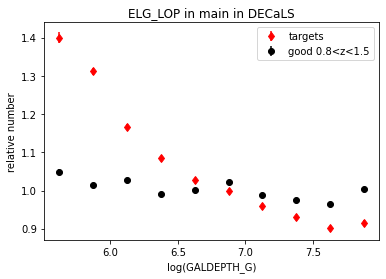

In [50]:
#just an example; note no split in BASS/MzLS / DECaLS and low completeness is probably pushing things for ELG 
selreg = fe['PHOTSYS'] == 'S'
selobs = fe['SPECTYPE'] != 'N/A'
selz = selobs & (fe['o2c'] > 0.9)
selz &= fe['Z'] > 0.8
selz &= fe['Z'] < 1.5

ec = fe[selz&selreg]
hd = np.histogram(np.log(fe[selreg]['GALDEPTH_G']),range=(5.5,8.))
hdo = np.histogram(np.log(ec['GALDEPTH_G']),weights=1./ec['COMP_TILE'],range=(5.5,8.))
selr = fer['PHOTSYS'] == 'S'
hr = np.histogram(np.log(fer[selr]['GALDEPTH_G']),bins=hd[1])
norm = sum(hr[0])/sum(hd[0])
normo = sum(hr[0])/sum(hdo[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
plt.errorbar(xl,hd[0]/hr[0]*norm,np.sqrt(hd[0])/hr[0]*norm,fmt='rd',label='targets')
plt.errorbar(xl,hdo[0]/hr[0]*normo,np.sqrt(hdo[0])/hr[0]*norm,fmt='ko',label='good 0.8<z<1.5')

plt.xlabel('log(GALDEPTH_G)')
plt.ylabel('relative number')
plt.title('ELG_LOP in main in DECaLS')
plt.legend()
plt.show()


<ipython-input-52-b671208e1916>:12: RuntimeWarning: divide by zero encountered in log
  hd = np.histogram(np.log(fe[selz2]['GALDEPTH_G']),weights=1./fe[selz2]['COMP_TILE'],range=(5.5,8.))


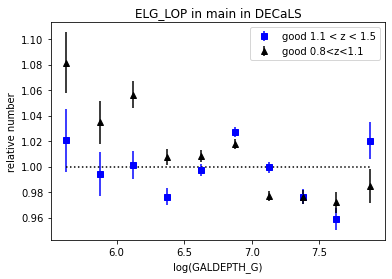

In [52]:
#just an example; note no split in BASS/MzLS / DECaLS and low completeness is probably pushing things for ELG 
selobs = fe['SPECTYPE'] != 'N/A'
selobs &= (fe['PHOTSYS'] == 'S')
selz = selobs & (fe['o2c'] > 0.9)
selz &= (fe['Z'] > 0.8)
selz &= (fe['Z'] < 1.1)
selz2 = selobs & (fe['o2c'] > 0.9)
selz2 &= (fe['Z'] > 1.1)
selz2 &= (fe['Z'] < 1.5)

ec = fe[selz]
hd = np.histogram(np.log(fe[selz2]['GALDEPTH_G']),weights=1./fe[selz2]['COMP_TILE'],range=(5.5,8.))
hdo = np.histogram(np.log(ec['GALDEPTH_G']),weights=1./ec['COMP_TILE'],range=(5.5,8.))
selr = fer['PHOTSYS'] == 'S'
hr = np.histogram(np.log(fer[selr]['GALDEPTH_G']),bins=hd[1])
norm = sum(hr[0])/sum(hd[0])
normo = sum(hr[0])/sum(hdo[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
plt.errorbar(xl,hd[0]/hr[0]*norm,np.sqrt(hd[0])/hr[0]*norm,fmt='bs',label='good 1.1 < z < 1.5')
plt.errorbar(xl,hdo[0]/hr[0]*normo,np.sqrt(hdo[0])/hr[0]*norm,fmt='k^',label='good 0.8<z<1.1')
ol = np.ones(len(xl))
plt.plot(xl,ol,'k:')
plt.xlabel('log(GALDEPTH_G)')
plt.ylabel('relative number')
plt.title('ELG_LOP in main in DECaLS')
plt.legend()
plt.show()


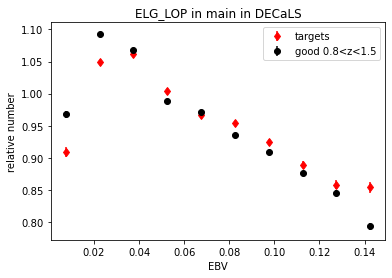

In [54]:
#just an example; note no split in BASS/MzLS / DECaLS and low completeness is probably pushing things for ELG 
selreg = fe['PHOTSYS'] == 'S'
selobs = fe['SPECTYPE'] != 'N/A'
selz = selobs & (fe['o2c'] > 0.9)
selz &= fe['Z'] > 0.8
selz &= fe['Z'] < 1.5

ec = fe[selz&selreg]
hd = np.histogram(fe[selreg]['EBV'],range=(0,.15))
hdo = np.histogram(ec['EBV'],weights=1./ec['COMP_TILE'],bins=hd[1])#,range=(5.5,8.))
selr = fer['PHOTSYS'] == 'S'
hr = np.histogram(fer[selr]['EBV'],bins=hd[1])
norm = sum(hr[0])/sum(hd[0])
normo = sum(hr[0])/sum(hdo[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
plt.errorbar(xl,hd[0]/hr[0]*norm,np.sqrt(hd[0])/hr[0]*norm,fmt='rd',label='targets')
plt.errorbar(xl,hdo[0]/hr[0]*normo,np.sqrt(hdo[0])/hr[0]*norm,fmt='ko',label='good 0.8<z<1.5')

plt.xlabel('EBV')
plt.ylabel('relative number')
plt.title('ELG_LOP in main in DECaLS')
plt.legend()
plt.show()


In [58]:
os.chdir('../py')

In [59]:
from LSS.imaging  import densvar

256 True


In [65]:
import healpy as hp

In [68]:
rth,rphi = densvar.radec2thphi(ec['RA'],ec['DEC'])
rpix = hp.ang2pix(densvar.nside,rth,rphi,nest=densvar.nest)
pixlg = np.zeros(12*densvar.nside*densvar.nside)
for ii in range(0,len(rpix)):#pix in rpix:
    pixlg[rpix[ii]] += 1./ec[ii]['COMP_TILE']

In [69]:
rth,rphi = densvar.radec2thphi(fer[selr]['RA'],fer[selr]['DEC'])
rpix = hp.ang2pix(densvar.nside,rth,rphi,nest=densvar.nest)
pixlr = np.zeros(12*densvar.nside*densvar.nside)
for ii in range(0,len(rpix)):#pix in rpix:
    pixlr[rpix[ii]] += 1.

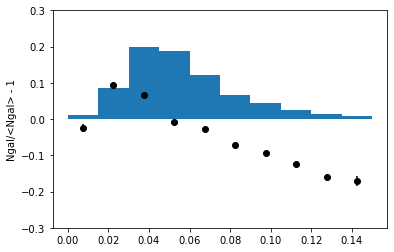

fraction of randoms not included in plot: 0.008197423240488388


([0.007499999832361937,
  0.022499999031424522,
  0.03750000149011612,
  0.05250000208616257,
  0.06750000268220901,
  0.08250000327825546,
  0.09749999642372131,
  0.11249999701976776,
  0.1274999976158142,
  0.14250001311302185],
 array([0.97536762, 1.09490912, 1.06576228, 0.99071466, 0.97185921,
        0.92879858, 0.90566335, 0.8755869 , 0.83946756, 0.82871989]),
 array([0.01186694, 0.00460541, 0.00299841, 0.00297116, 0.00366007,
        0.00478358, 0.00584285, 0.00764894, 0.0099189 , 0.01318402]))

In [74]:
parv = fitsio.read(densvar.pixfn)
densvar.plot_pixdens1d(pixlg,pixlr,parv['EBV'],np.ones(len(pixlg)),vmax=.15,vmin=0)

randoms done
data done
33987
33987


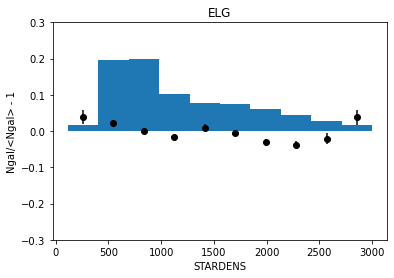

fraction of randoms not included in plot: 0.014473943680229785


([258.66278076171875,
  547.224609375,
  835.786376953125,
  1124.3482666015625,
  1412.9100341796875,
  1701.471923828125,
  1990.03369140625,
  2278.595458984375,
  2567.1572265625,
  2855.71923828125],
 array([1.03895046, 1.02094739, 1.00153879, 0.98233411, 1.00962119,
        0.99430673, 0.9685309 , 0.96210536, 0.97917267, 1.03755614]),
 array([0.02045432, 0.00576871, 0.00569626, 0.00781775, 0.00919054,
        0.00915916, 0.01016246, 0.01168789, 0.01533518, 0.01991254]))

In [61]:
densvar.densvsimpar_pix(fer,ec,'STARDENS',reg='S',xlab='STARDENS',titl='ELG',vmax=3000)#,vmin=vmin)

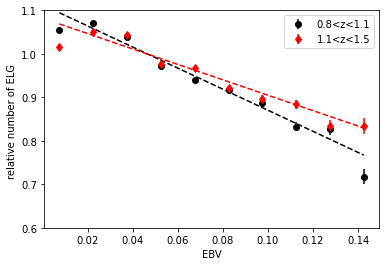

In [172]:
#just an example; note no split in BASS/MzLS / DECaLS and low completeness is probably pushing things for ELG 
selobs = fe['SPECTYPE'] != 'N/A'
#selobs &= fe['PHOTSYS'] == 'N'
selz = selobs & (fe['o2c'] > 0.9)
selz &= fe['Z'] > 0.8
selz &= fe['Z'] < 1.1
selr = fer['PHOTSYS'] == 'N'
selr |= fer['PHOTSYS'] == 'S'
ec = fe[selz]
hd = np.histogram(ec['EBV'],weights=1/ec['COMP_TILE'],range=(0,.15))
hr = np.histogram(fer[selr]['EBV'],bins=hd[1])
norm = sum(hr[0])/sum(hd[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
yl = hd[0]/hr[0]*norm
el = np.sqrt(hd[0])/hr[0]*norm

plt.errorbar(xl,yl,el,fmt='ko',label = '0.8<z<1.1')
m,b = np.polyfit(xl,yl,1,w=1/el)
plt.plot(xl,xl*m+b,'k--')
plt.xlabel('EBV')
plt.ylabel('relative number of ELG ')
#plt.ylim(0.6,1.1)
#plt.show()

selz = selobs & (fe['o2c'] > 0.9)
selz &= fe['Z'] > 1.1
selz &= fe['Z'] < 1.5

ec = fe[selz]
hd = np.histogram(ec['EBV'],weights=1/ec['COMP_TILE'],range=(0,.15))
hr = np.histogram(fer[selr]['EBV'],bins=hd[1])
norm = sum(hr[0])/sum(hd[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
yl = hd[0]/hr[0]*norm
el = np.sqrt(hd[0])/hr[0]*norm
plt.errorbar(xl,yl,el,fmt='rd',label='1.1<z<1.5')
m,b = np.polyfit(xl,yl,1,w=1/el)
plt.plot(xl,xl*m+b,'r--')

plt.xlabel('EBV')
#plt.ylabel('relative number of ELG with 1.1<z<1.6')
plt.ylim(0.6,1.1)
plt.legend()
plt.show()

In [193]:
#just an example; note no split in BASS/MzLS / DECaLS and low completeness is probably pushing things for ELG 
#selobs = fe['SPECTYPE'] != 'N/A'
#selobs &= fe['PHOTSYS'] == 'N'
#selz = selobs & (fe['o2c'] > 0.9)
fc = fitsio.read(indir+'ELG_LOPzdone_clustering.dat.fits',columns=['TARGETID','WEIGHT','WEIGHT_SYS'])
fej = join(fe,fc,keys=['TARGETID'],join_type='left')

In [196]:
sel = fc['WEIGHT'] == 0
print(len(fc[sel]))

6


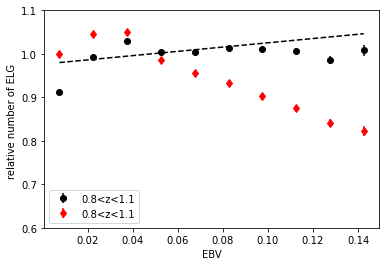

In [197]:
selobs = fej['SPECTYPE'] != 'N/A'
selobs &= fej['PHOTSYS'] == 'N'
selz = selobs & (fej['o2c'] > 0.9)

selz = fej['Z'] > 0.8
selz &= fej['Z'] < 1.6
selr = fer['PHOTSYS'] == 'N'
selr |= fer['PHOTSYS'] == 'S'
ec = fej[selz]
hd = np.histogram(ec['EBV'],weights=ec['WEIGHT'],range=(0,.15))
hr = np.histogram(fer[selr]['EBV'],bins=hd[1])
norm = sum(hr[0])/sum(hd[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
yl = hd[0]/hr[0]*norm
el = np.sqrt(hd[0])/hr[0]*norm

plt.errorbar(xl,yl,el,fmt='ko',label = '0.8<z<1.1')
m,b = np.polyfit(xl,yl,1,w=1/el)
plt.plot(xl,xl*m+b,'k--')
plt.xlabel('EBV')
plt.ylabel('relative number of ELG ')
#plt.ylim(0.6,1.1)
#plt.show()
hd = np.histogram(ec['EBV'],weights=1/ec['COMP_TILE'],range=(0,.15))
hr = np.histogram(fer[selr]['EBV'],bins=hd[1])
norm = sum(hr[0])/sum(hd[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
yl = hd[0]/hr[0]*norm
el = np.sqrt(hd[0])/hr[0]*norm

plt.errorbar(xl,yl,el,fmt='rd',label = '0.8<z<1.1')



plt.xlabel('EBV')
#plt.ylabel('relative number of ELG with 1.1<z<1.6')
plt.ylim(0.6,1.1)
plt.legend()
plt.show()

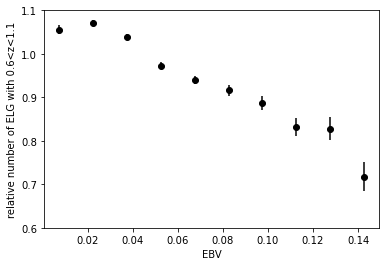

In [150]:
#just an example; note no split in BASS/MzLS / DECaLS and low completeness is probably pushing things for ELG 


## ok, yikes, look at dN/dz split on EBV

In [154]:
selebv = fe['EBV'] > 0.042
print(len(fe[selebv]),len(fe[~selebv]))

734573 761638


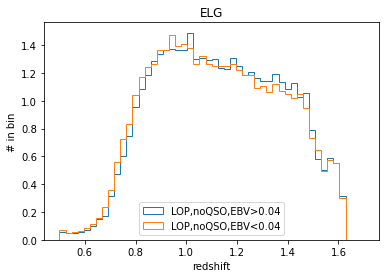

In [155]:
selobs = fe['SPECTYPE'] != 'N/A'
selgz = selobs & (fe['o2c'] > 0.9)
selnqgz = selgz & ((fe['DESI_TARGET'] & targetmask.desi_mask['QSO']) == 0)
selnvgz = selnqgz & ((fe['DESI_TARGET'] & targetmask.desi_mask['ELG_VLO']) == 0)
plt.hist(fe[selnvgz&selebv]['Z'],bins=50,range=(0.5,1.7),histtype='step',label='LOP,noQSO,EBV>0.04',density=True)
plt.hist(fe[selnvgz&~selebv]['Z'],bins=50,range=(0.5,1.7),histtype='step',label='LOP,noQSO,EBV<0.04',density=True)

plt.xlabel('redshift')
plt.ylabel('# in bin')
plt.legend(loc='lower center')
plt.title('ELG')
plt.show()

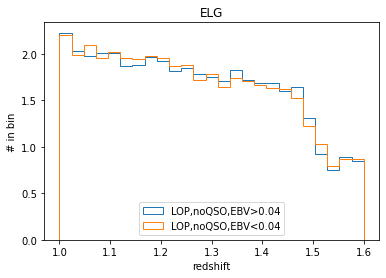

In [156]:
selobs = fe['SPECTYPE'] != 'N/A'
selgz = selobs & (fe['o2c'] > 0.9)
selnqgz = selgz & ((fe['DESI_TARGET'] & targetmask.desi_mask['QSO']) == 0)
selnvgz = selnqgz & ((fe['DESI_TARGET'] & targetmask.desi_mask['ELG_VLO']) == 0)
plt.hist(fe[selnvgz&selebv]['Z'],bins=25,range=(1,1.6),histtype='step',label='LOP,noQSO,EBV>0.04',density=True)
plt.hist(fe[selnvgz&~selebv]['Z'],bins=25,range=(1,1.6),histtype='step',label='LOP,noQSO,EBV<0.04',density=True)

plt.xlabel('redshift')
plt.ylabel('# in bin')
plt.legend(loc='lower center')
plt.title('ELG')
plt.show()

In [312]:
ff = fitsio.read('/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/20416/20210618/tile-qa-20416-thru20210618.fits')

In [313]:
ff.dtype.names

('TARGETID',
 'PETAL_LOC',
 'DEVICE_LOC',
 'LOCATION',
 'FIBER',
 'TARGET_RA',
 'TARGET_DEC',
 'MEAN_FIBER_X',
 'MEAN_FIBER_Y',
 'MEAN_DELTA_X',
 'MEAN_DELTA_Y',
 'RMS_DELTA_X',
 'RMS_DELTA_Y',
 'DESI_TARGET',
 'BGS_TARGET',
 'EBV',
 'TSNR2_LRG',
 'Z',
 'SPECTYPE',
 'DELTACHI2',
 'QAFIBERSTATUS',
 'EFFTIME_SPEC')

In [314]:
np.unique(ff['QAFIBERSTATUS'])

array([    0,     2,    10, 32768, 32769, 32771, 32777, 32779, 33536,
       33543, 33551, 33792, 33794, 33795, 33802, 33803, 34304, 34305,
       34306, 34307, 34312, 34313, 34314, 34315], dtype=int32)

In [317]:
ff = fitsio.read('/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/1237/20210611/zmtl-8-1237-thru20210611.fits')

In [318]:
ff.dtype.names

('RA',
 'DEC',
 'TARGETID',
 'DESI_TARGET',
 'BGS_TARGET',
 'MWS_TARGET',
 'SCND_TARGET',
 'Z',
 'ZWARN',
 'SPECTYPE',
 'DELTACHI2',
 'NUMOBS',
 'ZTILEID',
 'Z_QN',
 'Z_QN_CONF',
 'IS_QSO_QN')

In [11]:
ff = fitsio.read('/global/cfs/cdirs/desi/spectro/redux/everest/zcatalog/ztile-main-bright-cumulative.fits')

In [12]:
sel = ff['TILEID'] == 20846

In [13]:
ram = np.min(ff[sel]['TARGET_RA'])
rax = np.max(ff[sel]['TARGET_RA'])
decm = np.min(ff[sel]['TARGET_DEC'])
decx = np.max(ff[sel]['TARGET_DEC'])

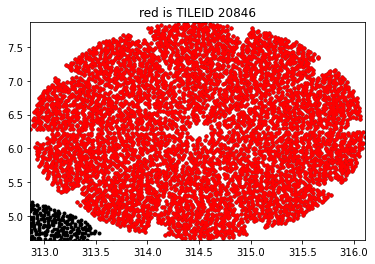

In [14]:
plt.plot(ff['TARGET_RA'],ff['TARGET_DEC'],'k.')
plt.plot(ff[sel]['TARGET_RA'],ff[sel]['TARGET_DEC'],'r.')

plt.xlim(ram,rax)
plt.ylim(decm,decx)
plt.title('red is TILEID 20846')
plt.show()

In [20]:
import datetime

In [25]:
today = datetime.date.today()

In [27]:
'20'+today.strftime("%y%m%d")

'20210922'

In [29]:
exps = Table.read('/global/cfs/cdirs/desi/spectro/redux/daily/exposure_tables/202109/exposure_table_20210921.csv')

In [31]:
len(exps)

69